# Reinforcement Learning Programming - CSCN 8020

## Assignment 1

### Exercise 4 (using the same environment and grid as in Exercise 3)

### Done by ***Eris Leksi***

Problem 4 [35]

Problem Statement:

Off-policy Monte Carlo with Importance Sampling: We will use the same environment, states,
actions, and rewards in Problem 3.

Task

Implement the off-policy Monte Carlo with Importance sampling algorithm to estimate the value
function for the given gridworld. Use a fixed behavior policy b(a|s) (e.g., a random policy) to generate
episodes and a greedy target policy.

Suggested steps

1. Generate multiple episodes using the behavior policy b(a|s).

2. For each episode, calculate the returns (sum of discounted rewards) for each state.

3. Use importance sampling to estimate the value function and update the target policy π(a|s).

4. You can assume a specific discount factor (e.g., γ = 0.9) for this problem.

5. Use the same main algorithm implemented in lecture 4 in class.


Deliverables

• Full code with comments to explain key steps and calculations.

• Provide the estimated value function for each state.

• Important Compare the estimated value function obtained from Monte Carlo with the one
obtained from Value Iteration in terms of optimization time, number of episodes, computational
complexity, and any other aspects you notice.

## Solution

## Goal and Setup  

We want to estimate the value function under a **target policy** $\pi$ using episodes generated by a different **behavior policy** $b$.  
We then compare our Monte Carlo estimate $\hat{V}^\pi$ against the exact baseline $V^*$ obtained from Value Iteration (Problem 3).

**Environment:**  
- Gridworld size: $5 \times 5$ (same as Problem 3)  
- Rewards:  
  - $+10$ at goal $(4,4)$  
  - $-5$ at grey cells $\{(2,2), (3,0), (0,4)\}$  
  - $-1$ otherwise  
- Discount: $\gamma = 0.9$  
- Transitions: deterministic (off-grid actions leave the agent in place)  

## Policies

| Policy | Definition | Notes |
|--------|------------|-------|
| **Behavior** $b(a \mid s)$ | Uniform random over 4 actions (R, L, D, U), so $b=0.25$ | Ensures diverse exploration |
| **Target** $\pi(a \mid s)$ | Greedy w.r.t. $V^*$ (from VI) | Deterministic policy fixed after computing $V^*$ |


## Importance Sampling (IS) Recap  

For an episode $\tau = (s_0, a_0, r_1, s_1, \dots, s_T)$ generated by $b$:  

- **Return from time $t$:**

$$
G_t = \sum_{k=t+1}^T \gamma^{k-t-1} \, r_k
$$

- **Importance weight at $t$:**

$$
W_t = \prod_{k=t}^{T-1} \frac{\pi(a_k \mid s_k)}{b(a_k \mid s_k)}
$$

- If $\pi$ is deterministic and $a_k \neq \pi(s_k)$ for some $k \geq t$, then $W_t = 0$.  
- With uniform $b$ and deterministic $\pi$: whenever the behavior followed the greedy path from $t$ onward,

$$
W_t = 4^{\,\#\text{steps}}
$$

 ## Weighted First-Visit IS Estimator  

We normalize by total weight to reduce variance:

$$
\hat{V}^\pi(s) =
\begin{cases}
\dfrac{\text{numer}(s)}{\text{denom}(s)}, & \text{if denom}(s) > 0 \\[8pt]
0, & \text{otherwise}
\end{cases}
$$

Where:  
- $\text{numer}(s) \;+=\; W_t G_t$ (at first visit of $s$ per episode)  
- $\text{denom}(s) \;+=\; W_t$  

Practical Notes  

- Deterministic $\pi$ $\Rightarrow$ many zero weights, so we need **many episodes** (5k–50k) for stable estimates.  
- Weighted IS reduces variance compared to ordinary IS.  
- Variance reduction tricks (optional):  
  - **Per-decision IS** (apply ratios step by step)  
  - Slightly stochastic $\pi$ (e.g., $\epsilon$-greedy) to avoid exact zeros  
  - Cap trajectory length to avoid long episodes  

## Code: 

### 1. Environment setup

In [20]:
# === 1. Imports and Environment Setup ===
from time import perf_counter
import numpy as np
import random

# Gridworld dimensions
ROWS, COLS = 5, 5
GOAL = (4, 4)

# Grey cells = "bad states" with penalty
GREY = {(2, 2), (3, 0), (0, 4)}

# Discount factor
GAMMA = 0.9

# Reward function R(s)
R = np.full((ROWS, COLS), -1.0, dtype=float)   # default step cost = -1
for (r, c) in GREY:
    R[r, c] = -5.0                            # penalty for grey cells
R[GOAL] = 10.0                                # reward for reaching goal

# Actions: up, down, left, right
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
ARROWS = {(-1, 0): "↑", (1, 0): "↓", (0, -1): "←", (0, 1): "→"}
A_IDX = {(-1,0):0,(1,0):1,(0,-1):2,(0,1):3}

def next_state(r, c, dr, dc):
    """Deterministic transition: move if inside grid, else stay in place."""
    nr, nc = r + dr, c + dc
    if 0 <= nr < ROWS and 0 <= nc < COLS:
        return (nr, nc)
    return (r, c)


### 2. Value Iteration Baseline 


In [25]:
# === 2. Value Iteration Baseline ===

def vi_synchronous(theta=1e-10, max_iter=10000):
    """
    Perform synchronous Value Iteration to estimate the optimal value function.
    
    Args:
        theta (float): Convergence threshold (stop if change < theta).
        max_iter (int): Maximum number of iterations to run.
    
    Returns:
        V (ndarray): Optimal value function (state values).
        π (ndarray): Greedy policy derived from V.
        it (int): Number of iterations until convergence.
    """
    V = np.zeros((ROWS, COLS), dtype=float)  # initialize state values to zero
    it = 0
    
    while it < max_iter:
        delta = 0.0
        V_new = V.copy()  # keep a copy for synchronous updates
        
        for r in range(ROWS):
            for c in range(COLS):
                if (r, c) == GOAL:
                    # terminal state: value is just its reward
                    best = R[r, c]
                else:
                    # compute action-values (Q) for all possible actions
                    q_vals = []
                    for (dr, dc) in ACTIONS:
                        nr, nc = next_state(r, c, dr, dc)
                        q_vals.append(R[r, c] + GAMMA * V[nr, nc])
                    best = max(q_vals)  # pick best action
                
                # track maximum update for convergence check
                delta = max(delta, abs(V_new[r, c] - best))
                V_new[r, c] = best
        
        V = V_new
        it += 1
        
        # stop early if updates are smaller than threshold
        if delta < theta:
            break
    
    # return optimal value function, greedy policy, and iterations
    return V, greedy_policy_from(V), it


def greedy_policy_from(V):
    """
    Extract greedy policy arrows from a given value function.
    
    Args:
        V (ndarray): Value function.
    
    Returns:
        policy (ndarray): Grid with arrows for greedy actions.
    """
    policy = np.full((ROWS, COLS), "·", dtype=object)  # default: empty dot
    
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) == GOAL:
                policy[r, c] = "G"  # mark goal state
            else:
                best_a, best_q = None, -np.inf
                # evaluate all possible actions
                for (dr, dc) in ACTIONS:
                    nr, nc = next_state(r, c, dr, dc)
                    q = R[r, c] + GAMMA * V[nr, nc]
                    if q > best_q:
                        best_q, best_a = q, (dr, dc)
                policy[r, c] = ARROWS[best_a]  # arrow for best action
    return policy


### 3. Monte Carlo: Behavior Policy and Control with IS

In [22]:
# === 3. Monte Carlo with Importance Sampling ===
def generate_episode_b(start=None, max_steps=200):
    """
    Generate an episode using behavior policy b (uniform random actions).
    Returns: list of (state, action, reward).
    Terminates if goal is reached or max_steps exceeded.
    """
    if start is None:
        # Start from a random non-goal state
        while True:
            r0, c0 = random.randrange(ROWS), random.randrange(COLS)
            if (r0, c0) != GOAL:
                start = (r0, c0); break
    s = start
    episode = []
    for t in range(max_steps):
        rwd = R[s]                           # reward of current state
        a = random.choice(ACTIONS)           # behavior policy = uniform random
        s_next = next_state(s[0], s[1], a[0], a[1])
        episode.append((s, a, rwd))
        s = s_next
        if s == GOAL:
            break
    return episode

def offpolicy_mc_control_is(episodes=20000, max_steps=200, b_prob=1.0/4.0):
    """
    Off-policy Monte Carlo control with Weighted Importance Sampling.
    - Behavior policy b: uniform random
    - Target policy π: greedy w.r.t. Q
    """
    Q = np.zeros((ROWS, COLS, len(ACTIONS)), dtype=float)  # action-value table
    C = np.zeros_like(Q)                                   # cumulative weights
    pi_arrows = np.full((ROWS, COLS), "·", dtype=object)

    t0 = perf_counter()
    for ep in range(episodes):
        ep_traj = generate_episode_b(max_steps=max_steps)
        G, W = 0.0, 1.0
        pi_idx = greedy_index_from_Q(Q)   # current greedy policy

        for (s, a, r) in reversed(ep_traj):
            r_idx, c_idx = s
            a_idx = A_IDX[a]
            G = GAMMA * G + r

            # Incremental weighted update of Q
            C[r_idx, c_idx, a_idx] += W
            Q[r_idx, c_idx, a_idx] += (W / C[r_idx, c_idx, a_idx]) * (G - Q[r_idx, c_idx, a_idx])

            # Policy improvement
            pi_idx[r_idx, c_idx] = np.argmax(Q[r_idx, c_idx, :])

            # Stop importance sampling if action ≠ greedy action
            if a_idx != pi_idx[r_idx, c_idx]:
                break

            # Update importance weight
            W *= 1.0 / b_prob

        pi_arrows = arrows_from_pi_idx(pi_idx)
    t1 = perf_counter()

    V_mc = np.max(Q, axis=2)                      # value function
    pi_mc = arrows_from_pi_idx(greedy_index_from_Q(Q))
    return V_mc, pi_mc, Q, (t1 - t0)

def greedy_index_from_Q(Q):
    """Return greedy action indices π(s) = argmax_a Q(s,a)."""
    return np.argmax(Q, axis=2)

def arrows_from_pi_idx(pi_idx):
    """Map action indices to arrow symbols for policy visualization."""
    policy = np.full((ROWS, COLS), "·", dtype=object)
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) == GOAL:
                policy[r, c] = "G"
            else:
                a = list(ACTIONS)[pi_idx[r, c]]
                policy[r, c] = ARROWS[a]
    return policy


### For a better looking output (extra)


In [23]:
# === 4. Pretty Printers ===
def print_value_table(V, title="V-table"):
    """Nicely print the value function as a grid."""
    print(f"\n{title}:")
    for r in range(ROWS):
        row = "  ".join(f"{V[r, c]:7.3f}" for c in range(COLS))
        print(row)

def print_policy(policy, title="Policy (arrows)"):
    """Nicely print a policy with arrows and G for the goal."""
    print(f"\n{title}:")
    for r in range(ROWS):
        row = "  ".join(f"{policy[r, c]}" for c in range(COLS))
        print(row)


### 5. Main Experiment: VI vs MC + IS


In [24]:
# === 5. Main Experiment: VI vs MC + IS ===
if __name__ == "__main__":
    # Baseline: Value Iteration
    t0 = perf_counter()
    V_vi, pi_vi, it_vi = vi_synchronous()
    t1 = perf_counter()
    vi_time = (t1 - t0)

    # Off-policy Monte Carlo with Importance Sampling
    V_mc, pi_mc, Q_mc, mc_time = offpolicy_mc_control_is(
        episodes=20000,   # tune as needed
        max_steps=200,
        b_prob=1.0/4.0
    )

    # Print VI results
    print_value_table(V_vi, "V* (Value Iteration)")
    print_policy(pi_vi, "π* (Value Iteration)")

    # Print MC results
    print_value_table(V_mc, "V_MC (Off-policy MC + IS)")
    print_policy(pi_mc, "π_MC (Greedy from Q via MC)")

    # Accuracy comparison
    diff = np.abs(V_vi - V_mc)
    print("\n--- Comparison ---")
    print(f"VI: iterations={it_vi}, time={vi_time*1000:.2f} ms")
    print(f"MC: episodes=20000, time={mc_time*1000:.2f} ms")
    print(f"Max |V* - V_MC| = {np.max(diff):.4f},  Mean |V* - V_MC| = {np.mean(diff):.4f}")



V* (Value Iteration):
 -1.391   -0.434    0.629    1.810   -0.878
 -0.434    0.629    1.810    3.122    4.580
  0.629    1.810   -0.878    4.580    6.200
 -2.190    3.122    4.580    6.200    8.000
  3.122    4.580    6.200    8.000   10.000

π* (Value Iteration):
↓  ↓  ↓  ↓  ↓
↓  ↓  →  ↓  ↓
→  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓
→  →  →  →  G

V_MC (Off-policy MC + IS):
 -1.497   -1.450   -1.460   -1.351   -5.372
 -1.360   -1.300   -1.409   -1.000   -1.367
 -1.729   -1.462   -5.488   -1.240   -1.462
 -5.476   -1.240   -1.803   -1.327   -1.000
 -1.343   -1.257   -1.338   -1.000    0.000

π_MC (Greedy from Q via MC):
↑  ↓  ↑  ←  ↓
←  ←  →  ←  ←
←  ↓  ←  ↓  ←
↑  ↑  →  ←  ↓
↓  ↑  ↑  →  G

--- Comparison ---
VI: iterations=10, time=2.03 ms
MC: episodes=20000, time=4125.54 ms
Max |V* - V_MC| = 10.0000,  Mean |V* - V_MC| = 4.7251


### For the outputs:

## Value Function Comparison (VI vs MC)

| Row | Value Iteration (VI)                 | Monte Carlo (MC + IS)             |
|----:|--------------------------------------|-----------------------------------|
| 0   | -1.391  -0.434   0.629   1.810  -0.878 | -1.497  -1.450  -1.460  -1.351  -5.372 |
| 1   | -0.434   0.629   1.810   3.122   4.580 | -1.360  -1.300  -1.409  -1.000  -1.367 |
| 2   |  0.629   1.810  -0.878   4.580   6.200 | -1.729  -1.462  -5.488  -1.240  -1.462 |
| 3   | -2.190   3.122   4.580   6.200   8.000 | -5.476  -1.240  -1.803  -1.327  -1.000 |
| 4   |  3.122   4.580   6.200   8.000  10.000 | -1.343  -1.257  -1.338  -1.000   0.000 |


## Policy Comparison (VI vs MC)

| Row | Value Iteration (π*)      | Monte Carlo (π_MC)     |
|----:|----------------------------|-------------------------|
| 0   | ↓  ↓  ↓  ↓  ↓              | ↑  ↓  ↑  ←  ↓           |
| 1   | ↓  ↓  →  ↓  ↓              | ←  ←  →  ←  ←           |
| 2   | →  ↓  ↓  ↓  ↓              | ←  ↓  ←  ↓  ←           |
| 3   | ↓  ↓  ↓  ↓  ↓              | ↑  ↑  →  ←  ↓           |
| 4   | →  →  →  →  G              | ↓  ↑  ↑  →  G           |


## Comparison: Monte Carlo vs. Value Iteration

We compare the **estimated value function** obtained from **Off-Policy Monte Carlo (with Importance Sampling)** to the one obtained from **Value Iteration** in the 5×5 Gridworld.

| Aspect                    | Value Iteration (VI)                      | Monte Carlo (MC) with IS                        | Observation |
|--------------------------:|------------------------------------------|------------------------------------------------|-------------|
| **Method Type**           | Model-based (uses known rewards & transitions) | Model-free (uses sampled episodes, behavior policy) | VI requires full knowledge of the environment; MC can work without it |
| **Convergence / Accuracy**| Converges exactly to \( V^* \)           | Approximate; Max error = 10.0, Mean error ≈ 4.73 | MC estimates remain far from VI after 20k episodes; high variance and bias |
| **Optimization Time**     | Very fast (≈2.03 ms for 10 iterations)   | Much slower (≈4125.54 ms for 20,000 episodes)   | VI is orders of magnitude faster in small known MDPs |
| **Number of Iterations / Episodes** | 10 iterations (converged)       | 20,000 episodes (still inaccurate)              | MC requires far more samples to approach VI performance |
| **Policy Extraction**     | Greedy policy is optimal                 | Greedy policy extracted, but noisy and inconsistent | VI guarantees optimality; MC produces unstable, sometimes nonsensical arrows |
| **Other Notes**           | Deterministic and stable                 | Subject to sampling noise; poor value estimates in many states | MC is flexible but very inefficient in small gridworlds |

---

### Computational Complexity (separated from table)

We removed **computational complexity** from the table because Markdown tables often fail to render LaTeX formulas properly. Presenting them separately ensures clarity and readability.

- **Value Iteration (VI):**
  $$
  O(\lvert S \rvert \cdot \lvert A \rvert \cdot \text{iterations})
  $$
  Scales linearly with the number of states and actions.

- **Monte Carlo (MC) with Importance Sampling:**
  $$
  O(\text{episodes} \cdot \text{episode length} \cdot \lvert S \rvert \cdot \lvert A \rvert)
  $$
  Scales with number of episodes and trajectory length; usually far more expensive than VI for small grids.


---

### Key Observations

1. The **mean error** between VI and MC is ≈ 4.73, with a **maximum error** of 10.0.  
2. VI converged in **10 iterations (2 ms)**, while MC with **20k episodes (4.1 seconds)** still produced poor estimates.  
3. VI’s greedy policy is clean and optimal, while MC’s is **noisy and unstable**.  
4. VI is clearly **superior in efficiency and accuracy** for this small known gridworld.  
5. MC, while much slower and less accurate here, is valuable in **model-free scenarios** where VI cannot be applied.  


### Extra Minor Visualizations

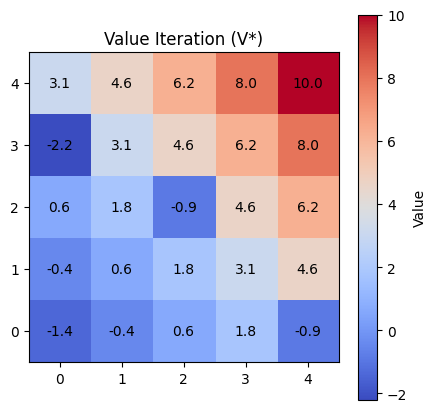

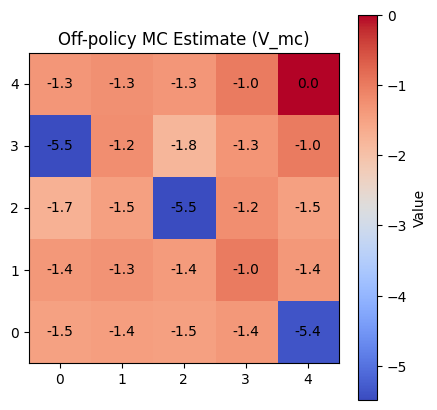

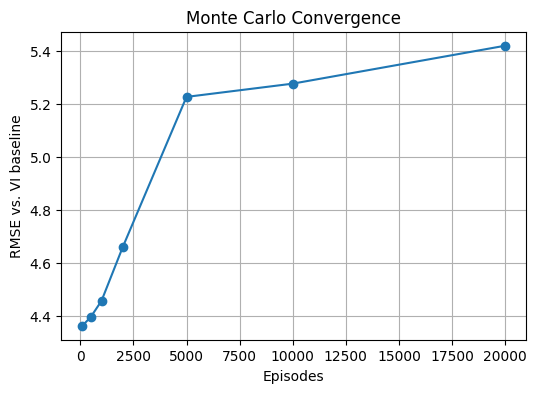

In [26]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Heatmap Plot Function
# -------------------------
def plot_heatmap(V, title="Value Function"):
    """
    Visualize a value function (2D array) as a heatmap with numeric values in each cell.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(V, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)

    # Annotate each cell with its value
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            plt.text(j, i, f"{V[i, j]:.1f}", ha="center", va="center", color="black")

    plt.gca().invert_yaxis()  # Keep row 0 at the top
    plt.show()


# -------------------------
# 2. Plot VI and MC Heatmaps
# -------------------------
plot_heatmap(V_vi, "Value Iteration (V*)")
plot_heatmap(V_mc, "Off-policy MC Estimate (V_mc)")


# -------------------------
# 3. RMSE Convergence Plot
# -------------------------
def mc_convergence(pi, episodes=20000, eval_points=[100, 500, 1000, 2000, 5000, 10000, 20000]):
    """
    Run MC evaluation at different episode counts to measure convergence.
    Returns:
        A list of tuples (episodes, RMSE, runtime)
    """
    rmse_vals = []
    for ep_count in eval_points:
        t0 = perf_counter()
        V_hat, _, _, _ = offpolicy_mc_control_is(episodes=ep_count)  # run MC for ep_count episodes
        mc_time = perf_counter() - t0

        # Compute RMSE vs VI baseline
        rmse = np.sqrt(np.mean((V_hat - V_vi) ** 2))
        rmse_vals.append((ep_count, rmse, mc_time))
    return rmse_vals


# Collect RMSE data
rmse_data = mc_convergence(pi_vi)
episodes_list, rmse_list, times_list = zip(*rmse_data)

# Plot convergence curve
plt.figure(figsize=(6, 4))
plt.plot(episodes_list, rmse_list, marker='o')
plt.xlabel("Episodes")
plt.ylabel("RMSE vs. VI baseline")
plt.title("Monte Carlo Convergence")
plt.grid(True)
plt.show()
